# Homework I

In [2054]:
import networkx as nx
import numpy as np
import pandas as pd
import itertools as it
import scipy
import random 
import altair as alt
import altair_saver
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp

## Exercise 1

### Network Construction

In [2055]:
# Generate the Directed Graph
G = nx.DiGraph()

# Add edges with their ow weights
edges = [('o','b',{'capacity':2}),('o','a',{'capacity':2}),('a','d',{'capacity':1}),('b','d',{'capacity':1}),('b','c',{'capacity':2}),('c','d',{'capacity':1})]
G.add_edges_from(edges)

pos = {'o': [0,2], 'a': [2,4], 'b': [2,2], 'c': [2,0], 'd': [4,2] }

In [2056]:
nx.get_edge_attributes(G,'capacity')

{('o', 'b'): 2,
 ('o', 'a'): 2,
 ('b', 'd'): 1,
 ('b', 'c'): 2,
 ('a', 'd'): 1,
 ('c', 'd'): 1}

### Graphic Representation

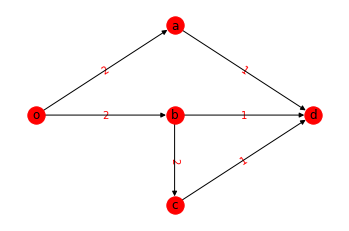

In [2057]:
pos = {'o': [0,2], 'a': [2,4], 'b': [2,2], 'c': [2,0], 'd': [4,2] }
nx.draw_networkx_edge_labels(G,pos,nx.get_edge_attributes(G,'capacity'),font_color='red')
nx.draw(G,pos,with_labels=True,node_color='red')
plt.savefig('Ex1.svg',dpi=180)

### Questions

(a) What is the minimum aggregate capacity that needs to be removed for no feasible flow from
*o* to *d* to exist?

The minumum aggregate capacity to remove in order to disconnect 2 nodes *i* and *j* is equals to the min-cut capacity for the **Network resilience interpretation** of **Max-flow Min-cut theorem**

In [2058]:
print('Min-cut Capacity:',nx.minimum_cut_value(G,'o','d'))

Min-cut Capacity: 3


Selecting any min-cut between *o* and *d*:

In [2059]:
min_cut = nx.minimum_cut(G,'o','d')[1]
min_cut

({'a', 'b', 'c', 'o'}, {'d'})

Removing capacity to edges passing though the selected min-cut we'll get *o* and *d* disconnected.

In [2060]:
GG = nx.DiGraph(G)

removed_capacity = 0
to_remove = []

for e in GG.edges:
    if e[0] in min_cut[0] and e[1] in min_cut[1]:
        removed_capacity += GG[e[0]][e[1]]['capacity']
        to_remove.append(e)

for e in to_remove:
    GG.remove_edge(*e)

Aggregate capacity removed: 3


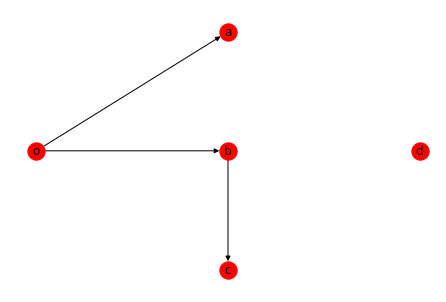

In [2061]:
nx.draw(GG,pos,with_labels=True,node_color='red')
plt.savefig('Ex1_a.svg',dpi=180)
print('Aggregate capacity removed:',removed_capacity)

### (b) What is the maximum aggregate capacity that can be removed from the links without affecting the maximum throughput from *o* to *d*?

Capacity can be removed without affecting throughput only by edges not passing through any min cut.

- $U=\{o,a,b,c\},U^C=\{d\} \rightarrow C_U = 3$
- $U=\{o,a,b\},U^C=\{c,d\} \rightarrow C_U = 4$
- $U=\{o,b,c\},U^C=\{a,d\} \rightarrow C_U = 4$
- $U=\{o,a\},U^C=\{b,c,d\} \rightarrow C_U = 3$
- $U=\{o,c\},U^C=\{a,b,d\} \rightarrow C_U = 5$
- $U=\{o\},U^C=\{a,b,c,d\} \rightarrow C_U = 4$

The min-cuts are $U=\{o,a,b,c\},U^C=\{d\}$ and $U=\{o,a\},U^C=\{b,c,d\}$.
The only edges not passing through any min-cut are $(o,a)$ and $(b,c)$

In [2062]:
GG = nx.DiGraph(G)

GG['o']['a']['capacity'] -= 1
GG['b']['c']['capacity'] -= 1

Decreasing by 1 each of these 2 nodes capacity we obtain:

- $U=\{o,a,b,c\},U^C=\{d\} \rightarrow C_U = 3$
- $U=\{o,a,b\},U^C=\{c,d\} \rightarrow C_U = 3$
- $U=\{o,b,c\},U^C=\{a,d\} \rightarrow C_U = 3$
- $U=\{o,a\},U^C=\{b,c,d\} \rightarrow C_U = 3$
- $U=\{o,c\},U^C=\{a,b,d\} \rightarrow C_U = 4$
- $U=\{o\},U^C=\{a,b,c,d\} \rightarrow C_U = 3$

In [2063]:
print('Max flow:',nx.maximum_flow_value(GG,'o','d'))

Max flow: 3


Maximum throughput has not been affected.

In [2064]:
unaffected_throughput = 0
for e in G.edges:
    GGG = nx.DiGraph(GG)
    GGG[e[0]][e[1]]['capacity'] -= 1
    if(nx.maximum_flow_value(GGG,'o','d') == nx.maximum_flow_value(G,'o','d')):
        unaffected_throughput += 1
        print(e)

if unaffected_throughput == 0:
    print('All edges affect Througput')


All edges affect Througput


Removing any other edge throughput will be affected.

(c) You are given x > 0 extra units of capacity. How should you distribute them in order to
maximize the throughput that can be sent from o to d? Plot the maximum throughput from
o to d as a function of x ≥ 0.

To check how adding *x* extra unit of capacity affects maximal throughput capacity should be added in order to balance capacity in-degree and out-degree for each node (obviously except *o* and *d*).
If this is balanced for all nodes in the graph a random edge belonging to any shortest path (in terms of number of edges) is incremented.

In [2065]:
df_dict = {'x':[],'thr_max':[]}
added_cap = 10
for x in range(added_cap):
    GG = nx.DiGraph(G)
    for i in range(x):
        thr = nx.maximum_flow_value(GG,'o','d')
        increased = False
        for n in GG.nodes:
            first_good = None
            in_d = GG.in_degree(n,'capacity')
            out_d = GG.out_degree(n,'capacity')
            if in_d < out_d:
                for e in GG.edges:
                    if e[1] == n:
                        if first_good == None:
                            first_good = e
                        GG[e[0]][e[1]]['capacity'] += 1
                        if nx.maximum_flow_value(GG,'o','d') > thr:
                            increased = True
                            break
                        GG[e[0]][e[1]]['capacity'] -= 1
            if increased:
                break
            elif in_d > out_d:
                for e in GG.edges:
                    if e[0] == n:
                        if first_good == None:
                            first_good = e
                        GG[e[0]][e[1]]['capacity'] += 1
                        if nx.maximum_flow_value(GG,'o','d') > thr:
                            increased = True
                            break
                        GG[e[0]][e[1]]['capacity'] -= 1
            if increased:
                break
        if not increased:
            if first_good == None:
                sh_paths = set(list(nx.all_shortest_paths(GG,'o','d'))[0]+list(nx.all_shortest_paths(GG,'o','d'))[1])
                random_edge = random.choice([e for e in GG.edges if e[0] in sh_paths and e[1] in sh_paths])
                #random_edge = random.choice()
                GG[random_edge[0]][random_edge[1]]['capacity'] += 1
            else:
                GG[first_good[0]][first_good[1]]['capacity'] += 1
                
    thr_max = nx.maximum_flow_value(GG,'o','d')
    if x%5 == 0:
        print(f"x = {x}, Throughput: {thr_max}")
        print("Capacities:",nx.get_edge_attributes(GG,'capacity'))
    df_dict['x'].append(x)
    df_dict['thr_max'].append(thr_max)

x = 0, Throughput: 3
Capacities: {('o', 'b'): 2, ('o', 'a'): 2, ('b', 'd'): 1, ('b', 'c'): 2, ('a', 'd'): 1, ('c', 'd'): 1}
x = 5, Throughput: 6
Capacities: {('o', 'b'): 4, ('o', 'a'): 2, ('b', 'd'): 2, ('b', 'c'): 2, ('a', 'd'): 2, ('c', 'd'): 2}


In [2066]:
df = pd.DataFrame(data=df_dict,columns=['x','thr_max'])

In [2067]:
df

,x,thr_max
0,0,3
1,1,4
2,2,4
3,3,5
4,4,5
5,5,6
6,6,6
7,7,7
8,8,7
9,9,8


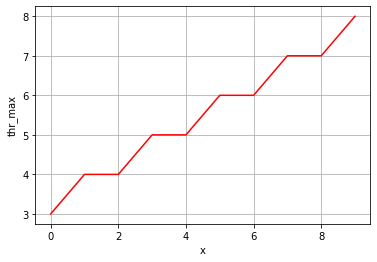

In [2068]:
fig, ax = plt.subplots()

p = sns.lineplot(ax=ax, data=df,x='x',y='thr_max',color='red')

p.grid()
plt.show()

fig.savefig('Ex1_c.svg',dpi=180)
#plt.savefig('Ex1_c.svg',dpi=180)

In the chart can be seen that the trend is periodic: every 2 units of caoacity added the maximal throughput increases by 1.

## Exercise 2

### Network Costruction

In [2070]:
edges = [('p1','b1'),('p1','b2'),('p2','b2'),('p2','b3'),('p3','b1'),('p3','b4'),('p4','b1'),('p4','b2'),('p4','b4')]

G = nx.DiGraph()
G.add_edges_from(edges)

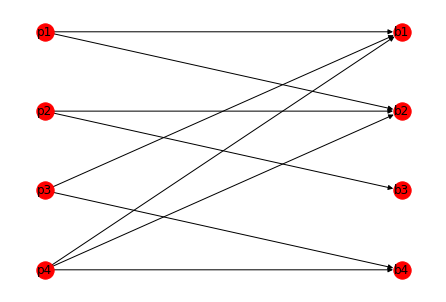

In [2071]:
pos = {'p1': [0,6], 'p2': [0,4], 'p3': [0,2], 'p4': [0,0], 'b1': [2,6] , 'b2': [2,4], 'b3':[2,2], 'b4':[2,0]}

nx.draw(G,pos,with_labels=True,node_color='red')

plt.savefig('Ex2.svg', dpi=180)

### (a) Exploit max-flow problems to find a perfect matching (if any).

In [2072]:
G2 = nx.DiGraph(G)

# Add origin and destination node
for n in range(1,5):
    G2.add_edge('o','p'+str(n))
    G2.add_edge('b'+str(n),'d')

In [2073]:
pos['o'] = [-1,3]
pos['d'] = [3,3]

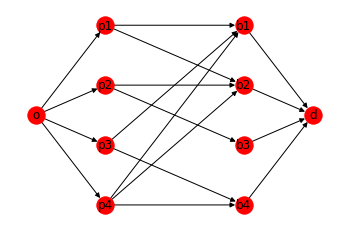

In [2074]:
nx.draw_networkx_edge_labels(G2,pos,nx.get_edge_attributes(G2,'capacity'),font_color='red')
nx.draw(G2,pos,with_labels=True,node_color='red')

plt.savefig('Ex2_a.svg',dpi=180)

In [2075]:
# Add capacity one for all edges
for e in G2.edges:
    G2[e[0]][e[1]]['capacity'] = 1

In [2076]:
# Compute the maximum flow
mf = nx.maximum_flow(G2,'o','d')

In [2077]:
mf[1]

{'p1': {'b1': 0, 'b2': 1},
 'b1': {'d': 1},
 'b2': {'d': 1},
 'p2': {'b2': 0, 'b3': 1},
 'b3': {'d': 1},
 'p3': {'b1': 1, 'b4': 0},
 'b4': {'d': 1},
 'p4': {'b1': 0, 'b2': 0, 'b4': 1},
 'o': {'p1': 1, 'p2': 1, 'p3': 1, 'p4': 1},
 'd': {}}

Beeing the maximum flow equal to the number of books and people, we can deduce that at least one perfect matching exists.

In [2078]:
perfect_dict = {}

# Obtain the perfect matching from the maziimum flow dictionary
for k, v in mf[1].items():
    if k[0] == 'p' and k != 'o' and k != 'd':
        for kk, vv in v.items():
            if vv == 1:
                perfect_dict[k] = kk

In [2079]:
perfect_dict

{'p1': 'b2', 'p2': 'b3', 'p3': 'b1', 'p4': 'b4'}

In [2080]:
# Confirm that the found matching is a perfect one
nx.is_perfect_matching(G, perfect_dict)

True

### (b) Assume now that there are multiple copies books, and the distribution of the number of copies is (2, 3, 2, 2). Each person can take an arbitrary number of different books. Exploit the analogy with max-flow problems to establish how many books of interest can be assigned in total.

All edges between people and books have capacity one because each person can take one copy of each book of interest.

In [2081]:
for e in G.edges:
    if e[1] in ['b1','b2','b3','b4']:
        G[e[0]][e[1]]['capacity'] = 1

Edges between books and destination have capacity according to the number of copies available in the library.

In [2082]:
for n in range(1,5):
    G.add_edge('o','p'+str(n))
    G.add_edge('b'+str(n),'d')

for e in G.edges:
    if e[1] == 'd':
        if e[0] in ['b1','b3','b4']:
            G[e[0]][e[1]]['capacity'] = 2
        elif e[0] == 'b2':
            G[e[0]][e[1]]['capacity'] = 3

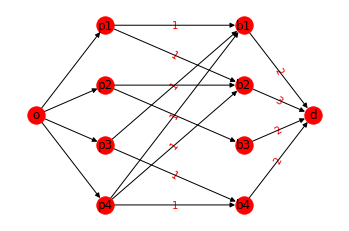

In [2083]:
pos['o'] = [-1,3]
pos['d'] = [3,3]

nx.draw_networkx_edge_labels(G,pos,nx.get_edge_attributes(G,'capacity'),font_color='red')
nx.draw(G,pos,with_labels=True,node_color='red')

plt.savefig('Ex2_b.svg',dpi=180)

To compute the number of books of interest that can be assigned, the maximum flow between *o* and *d* can be exploited.

In [2084]:
nx.maximum_flow_value(G,'o','d')

8

8 books of interest can be assigned.

### (c) Suppose that the library can sell a copy of a book and buy a copy of another book. Which books should be sold and bought to maximize the number of assigned books?

Try every couple of book-destinatination edges, increasing one and decreasing the other capacity, and select the one that maximize the maximum flow.

In [2085]:
books = ['b1','b2','b3','b4']

best_G = None
best_flow = nx.maximum_flow_value(G,'o','d')
bought = None
sold = None

for b in books:
    for bb in books:
        if b != bb:
            GG = nx.DiGraph(G)
            for e in GG.edges:
                if e[0] == b:
                    #inc_e = e
                    GG[e[0]][e[1]]['capacity'] += 1
                if e[0] == bb:
                    #dec_e = e
                    GG[e[0]][e[1]]['capacity'] -= 1
            if nx.maximum_flow_value(GG,'o','d') > best_flow:
                best_G = GG
                best_flow = nx.maximum_flow_value(GG,'o','d')
                bought = b
                sold = bb

In [2086]:
best_flow

9

In [2087]:
bought,sold

('b1', 'b3')

9 books of interest can be assigned selling copy of *b3* and buying a cpy of *b4*

## Exercise 3

### Construct network

In [2088]:
G = nx.DiGraph()

In [2089]:
pos = {1:[0,4],2:[1,4],3:[2,4],4:[3,4],5:[4,4],6:[0,3],7:[1,3],8:[2,3],9:[3,3],10:[1,2],11:[2,2],12:[3,2],13:[3.5,2],14:[4,2],15:[2,1],16:[3,1],17:[4,1]}

In [2090]:
# Load network data
f = scipy.io.loadmat('flow.mat')["flow"].reshape(28,)
C = scipy.io.loadmat('capacities.mat')["capacities"].reshape(28,)
B = scipy.io.loadmat('traffic.mat')["traffic"]
l = scipy.io.loadmat('traveltime.mat')["traveltime"].reshape(28,)

In [2091]:
# Add nodes and edges
for e in range(B.shape[1]):
    for i,n in enumerate(B[:,e]):
        if n == -1:
            for ii,ee in enumerate(B[:,e]):
                if ee == 1:
                    G.add_edge(ii+1,i+1)
        if n == 1:
            for ii,ee in enumerate(B[:,e]):
                if ee == -1:
                    G.add_edge(i+1,ii+1)


In [2092]:
# Sort edges according to the order of the picture
sorted_edges = [(1,2),(2,3),(3,4),(4,5),(1,6),(6,7),(7,8),(8,9),(9,13),(2,7),(3,8),(3,9),(4,9),(5,14),(6,10),(10,11),(10,15),(7,10),(8,11),(9,12),(11,12),(12,13),(13,14),(11,15),(13,17),(14,17),(15,16),(16,17)]

In [2093]:
# Add capacities
for i, e in enumerate(sorted_edges):
    G[e[0]][e[1]]['capacity'] = C[i]

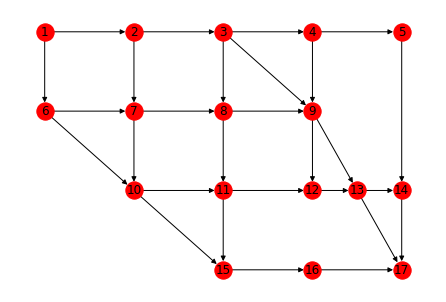

In [2094]:
nx.draw(G,pos,with_labels=True,node_color='red')

plt.savefig('Ex3.svg',dpi=180)

In [2095]:
# Add Travel Time
for i, e in enumerate(sorted_edges):
    G[e[0]][e[1]]['cost'] = l[i]

### (a) Find the shortest path between node 1 and 17. This is equivalent to the fastest path (path with shortest traveling time) in an empty network.

In order to find the fastest path between node *1* and node *17* it should be computed the shortest path in terms of Travel Time.

In [2096]:
fastest_path = nx.shortest_path(G,1,17,weight='cost')

In [2097]:
list(nx.all_shortest_paths(G,1,17,'cost'))

[[1, 2, 3, 9, 13, 17]]

In [2098]:
jas_path = [1,6,10,15,16,17]

In [2099]:
color = []
travel_time = 0
for e in G.edges:
    if e[0] in fastest_path and e[1] in fastest_path:
        color.append('red')
        travel_time += G[e[0]][e[1]]['cost']
    else:
        color.append('black')

Shortest Travel Time: 0.532996


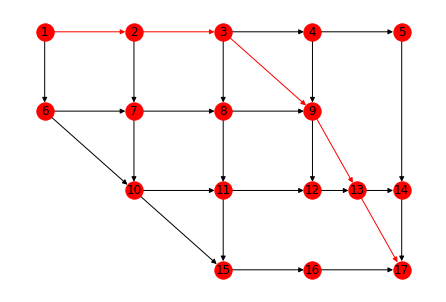

In [2100]:
nx.draw(G,pos,with_labels=True,edge_color=color,node_color='red')
plt.savefig('Ex3_a.svg',dpi=180)
print('Shortest Travel Time:',travel_time)


The fastest path in an empty network is **[1,2,3,9,13,17]** with travel time of **0.532996**

### (b) Find the maximum flow between node 1 and 17.

In [2125]:
nx.maximum_flow_value(G,1,17,'capacity')

22448

Maximum flow between node *1* and node *17* is **22448**.

### (c) Given the flow vector in flow.mat, compute the external inflow ν satisfying Bf = $\nu$.

The external inflow $\nu$ satisfying the mass conservation constraint is given by matrix product betrween Node-Link Incidence Matrix *B* and the given Flow vector *f*.

In [2102]:
v = B @ f

In [2103]:
print(list(v))

[16806, 8570, 19448, 4957, -746, 4768, 413, -2, -5671, 1169, -5, -7131, -380, -7412, -7810, -3430, -23544]


We assume that the exogenous inflow is zero in all the nodes except for node *1*, for which $\nu_1$ has the same value computed in the point (c), and node *17*, for which $\nu_{17} = −\nu_1$.

In [2104]:
nu = np.zeros(v.shape)

In [2105]:
nu[0] = v[0]
nu[-1] = -v[0]

### (d) Find the social optimum $f^*$ with respect to the delays on the different links $\tau_e(f_e)$. For this,minimize the cost function $\sum_{e\in\mathcal{E}}f_e\tau_e(f_e) = \sum_{e\in\mathcal{E}}\frac{f_el_e}{1-\frac{f_e}{c_e}} = \sum_{e\in\mathcal{E}}(\frac{l_ec_e}{1-\frac{f_e}{c_e}}-l_ec_e)$ subject to the flow constraints.

In [2106]:
# compute total dealy both for standard and new delay function
def compute_total_delay(f,func='standard'):
    if func == 'standard':
        return sum(l*C/(1-f/C)-l*C)
    elif func == 'new':
        return sum(l*C/(1-f/C)-l*C+f*C)

Computation of the social optimum $f^*$.

In [2107]:
f_var = cp.Variable(f.shape)

objective = cp.Minimize(cp.sum(cp.multiply(l*C,cp.inv_pos(1-f_var/C))- l*C))
constraints = [B @ f_var == nu, f_var >= 0, f_var <= C]

prob = cp.Problem(objective,constraints)

result = prob.solve()
#print(result)

f_star = f_var.value

print('Optimal f:',f_star)

Optimal f: [6.64219910e+03 6.05893789e+03 3.13232779e+03 3.13232589e+03
 1.01638009e+04 4.63831664e+03 3.00634073e+03 2.54263460e+03
 3.13154448e+03 5.83261212e+02 1.45164550e-02 2.92659559e+03
 1.89781986e-03 3.13232589e+03 5.52548426e+03 2.85427264e+03
 4.88644874e+03 2.21523712e+03 4.63720641e+02 2.33768761e+03
 3.31799129e+03 5.65567890e+03 2.37310712e+03 1.99567283e-03
 6.41411626e+03 5.50543301e+03 4.88645073e+03 4.88645073e+03]


In [2108]:
total_delay_f_star = compute_total_delay(f_star)

In [2109]:
total_delay_f_star

25943.62261121288

### (e1) Find the Wardrop equilibrium $f^{(0)}$ . For this, use the cost function $\sum_{e\in\mathcal{E}}\int_{0}^{f_e}\tau_e(s)\,ds$.

Computation of the Wardrop Equilibrium $f^{(0)}$.

In [2110]:
f_var = cp.Variable(f.shape)

objective = cp.Minimize(cp.sum(cp.multiply(-l*C,cp.log(1-cp.multiply(f_var,cp.inv_pos(C))))))

constraints = [B @ f_var == nu, f_var >= 0,f_var <= C]
prob = cp.Problem(objective,constraints)

result = prob.solve()
#print(result)

f_w = f_var.value

print('Optimal f:',f_w)

Optimal f: [6.71564895e+03 6.71564803e+03 2.36740801e+03 2.36740792e+03
 1.00903510e+04 4.64539489e+03 2.80384316e+03 2.28356194e+03
 3.41848003e+03 9.22328268e-04 1.76829408e+02 4.17141061e+03
 8.92024178e-05 2.36740792e+03 5.44495611e+03 2.35317044e+03
 4.93333832e+03 1.84155266e+03 6.97110629e+02 3.03649261e+03
 3.05028094e+03 6.08677356e+03 2.58651143e+03 1.24029072e-04
 6.91874216e+03 4.95391934e+03 4.93333845e+03 4.93333845e+03]


In [2111]:
total_delay_f_w = compute_total_delay(f_w)

In [2112]:
total_delay_f_w

26292.963874629393

### (e2) Introduce tolls, such that the toll on link e is $\omega_e = f_e\tau'_e(f_e^*)$, where $f_e^∗$ is the flow at the system optimum. Now the delay on link e is given by $τ_e(f_e)+ω_e$ . compute the new Wardrop equilibrium $f^{(ω)}$ . What do you observe?

Computation of Wardrop Equilibrium with tolls $f^{(\omega)}$.

In [2113]:
f_var = cp.Variable(f.shape)

omega = f_star*(C*l/((C-f_star)**2)) 

objective = cp.Minimize(cp.sum(-l*C @ cp.log(1-f_var/C)+cp.multiply(f_var,omega)))
constraints = [B @ f_var == nu, f_var >= 0, f_var <= C]

prob = cp.Problem(objective,constraints)

result = prob.solve()
#print(result)

f_w_tolls = f_var.value

print('Optimal f:',f_w_tolls)

Optimal f: [6.70985110e+03 6.70985086e+03 2.40098316e+03 2.40098314e+03
 1.00961489e+04 4.64702364e+03 2.80354413e+03 2.27990795e+03
 3.40793915e+03 2.35827155e-04 1.60447652e+02 4.14842005e+03
 1.77521811e-05 2.40098314e+03 5.44912522e+03 2.36499067e+03
 4.92761429e+03 1.84347974e+03 6.84083836e+02 3.02038887e+03
 3.04907448e+03 6.06946335e+03 2.57570513e+03 2.47813497e-05
 6.90169737e+03 4.97668827e+03 4.92761431e+03 4.92761431e+03]


In [2114]:
total_delay_f_w_tolls = compute_total_delay(f_w_tolls)

In [2115]:
total_delay_f_w_tolls

26271.429108843167

In [2116]:
# Price of Anarchy
print('PoA:',total_delay_f_w/total_delay_f_star)

PoA: 1.013465400289377


### (f) Instead of the total travel time, let the cost for the system be the total additional delay compared to the total delay in free flow, given by $\psi_e(f_e) = f_e(τ_e(f_e)−l_e)$ subject to the flow constraints. Compute the system optimum $f^*$ for the costs above. Construct tolls $ω^∗$ such that the Wardrop equilibrium $f^{(ω^∗)}$ coincides with $f^∗$. Compute the new Wardrop equilibrium with the constructed tolls $f^{(ω^∗)}$ to verify your result.

Computation of the new Social Optimum $f^*$.

In [2117]:
f_var = cp.Variable(f.shape)

objective = cp.Minimize(cp.sum(cp.multiply(l*C,cp.inv_pos(1-f_var/C))- l*C - cp.multiply(f_var,l)))

constraints = [B @ f_var == nu, f_var >= 0,f_var <= C]
prob = cp.Problem(objective,constraints)

result = prob.solve()
#print(result)

f_star_new = f_var.value

print('Optimal f:',f_star_new)

Optimal f: [6.65329658e+03 5.77466230e+03 3.41971657e+03 3.41971062e+03
 1.01527034e+04 4.64278036e+03 3.10584008e+03 2.66218478e+03
 3.00907935e+03 8.78634280e+02 7.42401749e-03 2.35493830e+03
 5.94907576e-03 3.41971062e+03 5.50992306e+03 3.04369256e+03
 4.88180506e+03 2.41557456e+03 4.43662730e+02 2.00804968e+03
 3.48735309e+03 5.49540277e+03 2.20377848e+03 2.20338871e-03
 6.30070364e+03 5.62348910e+03 4.88180726e+03 4.88180726e+03]


In [2118]:
total_delay_f_star_new = compute_total_delay(f_star_new,'new')

In [2119]:
total_delay_f_star_new

1002795968.2529671

Construct tolls $\omega^*$.

In [2120]:
w_var = cp.Variable(l.shape)

objective = cp.Minimize(cp.sum(-cp.multiply(l*C,cp.log(1-cp.multiply(f_star_new,cp.inv_pos(C)))) - f_star_new*l + cp.multiply(f_star_new,w_var)))
#objective = cp.Minimize(cp.sum(cp.multiply(-l*C,cp.log(1-cp.multiply(f_star_new,cp.inv_pos(C)))) - (f_star_new**2)*l/2 + cp.multiply(f_star_new,w_var)))

constraints = [w_var >= 0]

prob = cp.Problem(objective,constraints)

result = prob.solve()
#print(result)

w_star_opt = w_var.value

print('Optimal w*:',w_star_opt)

Optimal w*: [-5.87275093e-16 -4.87717810e-16  3.12056271e-17  3.12390244e-17
 -8.12982074e-16 -3.03961469e-16  1.59827547e-16  3.93267366e-16
  2.04877686e-16  3.71065951e-15  5.39301448e-10  6.06501589e-16
  6.67533797e-10  3.12386131e-17 -4.51559991e-16  1.88402577e-16
 -3.49859506e-16  5.60153831e-16  8.56513165e-15  9.25679538e-16
  6.52682972e-18 -4.49472639e-16  7.33228033e-16  1.74839837e-09
 -5.50717233e-16 -4.67453391e-16 -3.49860181e-16 -3.49860181e-16]


Compute the new Wardrop Equilibrium $f^{(\omega)}$.

In [2121]:
f_var = cp.Variable(f.shape)

#objective = cp.Minimize(cp.sum(cp.multiply(-l*C,cp.log(1-cp.multiply(f_var,cp.inv_pos(C)))) - cp.multiply(f_var,l) + cp.multiply(f_var,w_star_opt)))
objective = cp.Minimize(cp.sum(-cp.multiply(l*C,cp.log(1-cp.multiply(f_var,cp.inv_pos(C)))) - cp.multiply(f_var,l) + cp.multiply(f_var,w_star_opt)))

constraints = [B @ f_var == nu, f_var >= 0,f_var <= C]
prob = cp.Problem(objective,constraints)

result = prob.solve()
#print(result)

f_w_tolls_new = f_var.value

print('Optimal f with w*:',f_w_tolls_new)

Optimal f with w*: [6.78171987e+03 6.00489786e+03 3.26626180e+03 3.26625112e+03
 1.00242801e+04 4.66556319e+03 3.02889528e+03 2.64103860e+03
 3.03881965e+03 7.76822009e+02 2.40314706e+02 2.49832135e+03
 1.06787614e-02 3.26625112e+03 5.35871687e+03 2.88151848e+03
 4.89068831e+03 2.41348992e+03 6.28171384e+02 2.10055098e+03
 3.50968837e+03 5.61023936e+03 2.26259356e+03 1.49121230e-03
 6.38646544e+03 5.52884468e+03 4.89068980e+03 4.89068980e+03]


In [2122]:
total_delay_f_w_tolls_new = compute_total_delay(f_w_tolls_new,'new')

In [2123]:
total_delay_f_w_tolls_new

1003639627.5199927

In [2124]:
#Price of Anarchy
print('PoA: ',total_delay_f_w_tolls_new/total_delay_f_star_new)

PoA:  1.0008413069993645
